In [ ]:
# importing the libraries 
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
import nltk.tokenize as tokenize
import re
import string
from collections import defaultdict
import csv
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from scipy.sparse import csr_matrix
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, confusion_matrix

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasetProject.csv")

In [ ]:
# For Junior
#data=pd.read_csv("/content/drive/MyDrive/NLP/datasetProject.csv")

In [ ]:
# We can see that the data consisits of 50000 reviews , with equal number of positve and negative reviews
print(data.shape)
data.sentiment.value_counts()

(50000, 2)


positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


First thing we need to do is process the input , so we can make useful inputs to the model-
* Lowercase the reviews.
* remove all the stopwords ( common words lke the ,a etc) and punctuations from the reviews.
* stem the words , we dont want to count dance , danced , dancing as different words , so when we stem it , the output becomes danc for all the three, and is only taken once in the vocab building.

In [ ]:
poslens = data[data['sentiment']=='positive']['review'].str.len()
neglens = data[data['sentiment']=='negative']['review'].str.len()
fig = go.Figure()
fig.add_trace(
    go.Histogram(x=poslens, xbins=dict(size=200), name='positive'),
    )
fig.add_trace(
    go.Histogram(x=neglens, xbins=dict(size=200), name='negative'),
    )
fig.update_layout(title='Length of reviews', 
                    xaxis_title="Length",
                    yaxis_title="# of reviews",)
plotly.offline.iplot(fig)

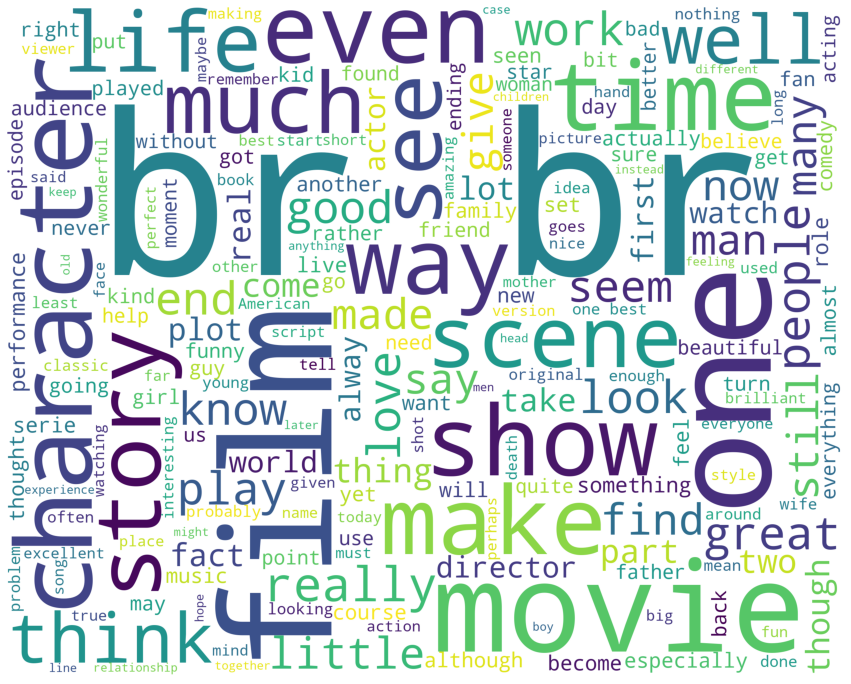

In [ ]:
df_pos = data[data['sentiment']=='positive']['review']

wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))

plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

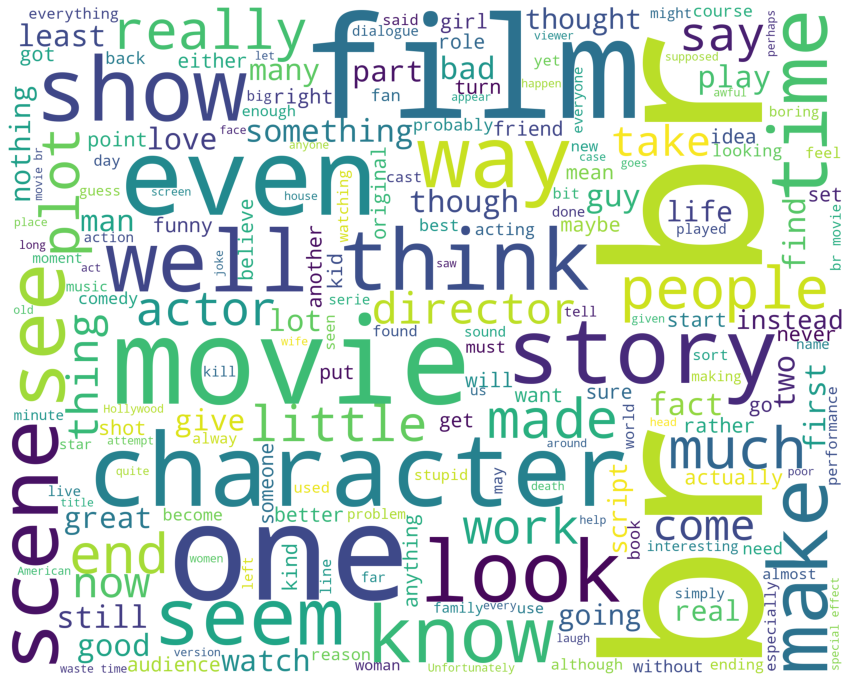

In [ ]:
df_neg = data[data['sentiment']=='negative']['review']

wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))

plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

In [ ]:
datamini=data.iloc[:10,:]

In [ ]:
datamini.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
len(datamini)

10

In [ ]:
def preprocessing(data,mode):# mode=train or eval

  def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr, ' ', sentence)
    return cleantxt

  def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned
  ## For Junior (byte decode)
  sno = nltk.stem.SnowballStemmer("english")
  stop = set(stopwords.words("english"))
  final_string = []
  str1 = ''
  i = 0
  for string in data:
    filtered_sentence = []
    # Removes html tags from every review
    sent = cleanHtml(string)
    for w in sent.split():
        # For every word in a review clean punctions
        for cleanwords in cleanpunc(w).split():
            # if cleaned is alphabet and length og words greater than 2 then proceed
            if ((cleanwords.isalpha()) and len(cleanwords)>2):
                # check weather word is stop word or not
                if cleanwords.lower() not in stop:
                    # If word is not stop word then append it to filtered sentence
                    s = (sno.stem(cleanwords.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue
    # filtered_sentence is list contains all words of a review after preprocessing
    # join every word in a list to get a string format of the review

    #str1 = b' '.join(filtered_sentence)
   

    

    str1 = ' '.join(map(bytes.decode, filtered_sentence))
    #append all the string(cleaned reviews)to final_string
    final_string.append(str1)
    i += 1 
   #build the vocabulary
  words={}
  if mode=="train":
    
    for sentence in final_string:
      
      # Split sentence using white space
      a = sentence.split()
      for item in a:
        if item not in words.keys():
           words[item]=1
    
  return  final_string,words    

In [ ]:
# Iterate over items in list
def new_dataframe(df, f,voca,mode):

  def conv_label(label):
    if label.lower() == "positive":
      return 1
    elif label.lower() == "negative":
      return 0

  
  #create the bag words. representation
  list1=[]
  for i in range(len(df)):
    list1.append([int(m in df[i]) for m in voca.keys()])
#We create here our dataframe
  dic={}
  array_1=np.array(list1)
  i=0
  for item in voca.keys():
    dic[item]=array_1[:,i]
    i+=1
  if mode=="train":
    dic["sentiment"]= f["sentiment"].map(conv_label)

  data1=pd.DataFrame(dic)

  return data1

In [ ]:
class BernoulliNaiveBayes:
    
    def __init__(self, alpha = 1):
        self.alpha = alpha
        return
    
    def fit(self, X, y):
        
        # count number of occurrences for each label
        y_counts = np.unique(y, return_counts=True)[1]
        
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        
        # calculate P(y), the probability of observing any message of class y
        class_prior = y_counts / y_counts.sum()
        self.log_class_prior = np.expand_dims(np.log(class_prior), axis = 1)
        
        # calculate P(x|y), the probability of observing message x given it is class y
        prob_x_given_y = np.zeros([self.n_classes, self.n_features])
        
        # for each class of y
        for i in range(self.n_classes):
            
            # select only rows of class y
            row_mask = (y == i) 
            X_filtered = X[row_mask, :]
            
            # get number of messages of each word appears in ( P(x and y) )
            numerator = (X_filtered.sum(axis = 0) + self.alpha)
            
            # get number messages in class y (scalar) ( P(y) )
            denominator = (X_filtered.shape[0] + 2 * self.alpha)
            
            # P(x|y) = P(x and y) / P(y)
            prob_x_given_y[i, :] = numerator / denominator
            
        # Calculate log probabilities for P(x|y) and P(~x|y)
        self.log_class_conditional_positive = np.log(prob_x_given_y) # k x n matrix
        self.log_class_conditional_negative = np.log(1 - prob_x_given_y) # k x n matrix
            
    def predict(self, X):
        
        #X = X.todense() # m x d matrix
        
        # log P(y|x) is proportional to log P(x|y) + log P(y)
        # each n x 1 column vector is contains a value proportional to P(y|x)
        # for every possible class of y
        log_probs_positive = self.log_class_conditional_positive.dot(X.T) # n x m matrix
        log_probs_negative = self.log_class_conditional_negative.dot(1 - X.T) # n x m matrix        
        log_likelihoods = log_probs_positive + log_probs_negative # n x m matrix
        log_joint_likelihoods = log_likelihoods + self.log_class_prior # n x m matrix
        
        # for each column vector, find class y that maximizes P(y|x)
        preds = np.argmax(log_joint_likelihoods, axis = 0) # 1 x m matrix
        preds = np.array(preds).squeeze() # m-dimensional vector
        return preds

In [ ]:
def split_data(df, train_percent):
  ########## fill the code ########
  np.random.seed(1)
  perm=np.random.permutation(df.index)

  n=len(df)

  train_index=int(train_percent * n)
  train=df.iloc[perm[:train_index]]
  test=df.iloc[perm[train_index : ]]

  X_train = train.iloc[:, : -1]
  Y_train = train.iloc[:, -1]

  X_test = test.iloc[:, :-1]
  Y_test = test.iloc[:,-1]

  return X_train, X_test, Y_train, Y_test

In [ ]:
clean_data,vocabulary=preprocessing(datamini['review'].values, mode="train")
Good_data=new_dataframe(clean_data, datamini,voca=vocabulary, mode="train")

In [ ]:
Good_data.head()

,one,review,mention,watch,episod,youll,hook,right,exact,happen,...,bit,effort,obsess,gut,wrench,laughter,hell,mom,camp,sentiment
0,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
len(Good_data)

10

In [ ]:
X_train, X_test, y_train, y_test =split_data(Good_data, 0.8)

In [ ]:
len(X_train)

8

In [ ]:
X_train.shape, y_train.shape

((8, 524), (8,))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(np.array(Good_data.iloc[:,:-1]), np.array(Good_data['sentiment']),
                                                  #  test_size = 0.2)

In [ ]:
bnb = BernoulliNaiveBayes(alpha = 0.001)
bnb.fit(np.array(X_train), np.array(y_train))
y_pred = bnb.predict(X_test)
print('test accuracy:', accuracy_score(y_test, y_pred)*100)
print('macro f1 score:', f1_score(y_test, y_pred, average='macro')*100)

test accuracy: 50.0
macro f1 score: 33.33333333333333


In [ ]:
def predict_new(x_new):
  df=pd.DataFrame({"Sentence":[x_new]})
  x,_=preprocessing(df['Sentence'].values,mode="test")
  x_new=new_dataframe(x, f=None,voca=vocabulary, mode="test")
  #print(x_new.shape)
  return bnb.predict(x_new)

In [ ]:
predict_new("I am eating salade, watching movies with friends. we are going to the beach today")

array(1)